#Grain Boundary Detection
This notebook demostrates the training and usage of U-net model for grain boundary data. <br>
<b>Note:</b> The original dataset is processed on Dell Precision T7610 Workstation with NVIDIA GeForce RTX3900 GPU. Due to resource limitation on Colab, a few modifications are made:
<ul>
<li>Training data set is reduced to 300 image pairs.</li>
<li>Small version of U-net is used. See `unet_training.py` for details</li>
<li>Batch size is reduced from 64 to 8.</li>
<li>Maximum number of epoches is reduced from 200 to 20.</li> 
</ul>
This notebook has been tested on Colab with GPU runtime. Training data is available upon reasonable request.

###View input data
The original dm4 images are converted to numpy array (saved as `.npy` format). Drift correction has been performed on the image sequence.
We start with the following files:
<ul> 
<li>drift_corrected_array This folder contains drift corrected raw images. 
</li>
<li>`average_254.png` This files is obtained by averaging all drift corrected raw images. Note that due to drift, only the center part of the image which is present in all frames, therefore only the center part is used here. The averaged image is normalised to range 0-254 and then converted to unsigned 8-bit image. (Pixel intensity 255 is reserved for manual labelling of grain boundaries)
</li>
<li> binary.png Grain boundary is manually labeled from average_254.png, and then extracted as binary image.
</li>
<li> test_image.npy This is a different grain boundary image, which will be used to validate training result.
</li>

</ul>

In [ ]:
%matplotlib inline

import os, sys
import numpy as np
import cv2
from matplotlib import pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Colab Notebooks/grain/data'  #input images stored here
save_dir = '/content/drive/MyDrive/Colab Notebooks/grain/data'  #intermediate results will be saved here
sys.path.append(os.path.abspath('/content/drive/MyDrive/Colab Notebooks/grain/scripts/'))   #python scripts stored here

Mounted at /content/drive


In [ ]:
# view drift corrected raw images

#~ GET LIST OF FILES FOR CONVERSION
def getFiles(path,type='png'):
	inputFileList=[]
	for root, dirs, files in os.walk(path):
		for name in files:
			if name.endswith((type)):
				inputFileList.append(os.path.join(root,name))
	return inputFileList

raw_dir = os.path.join(data_dir, 'drift_corrected_array')
raw_file_list = getFiles(raw_dir, 'npy')
raw_file_list = np.sort(raw_file_list)


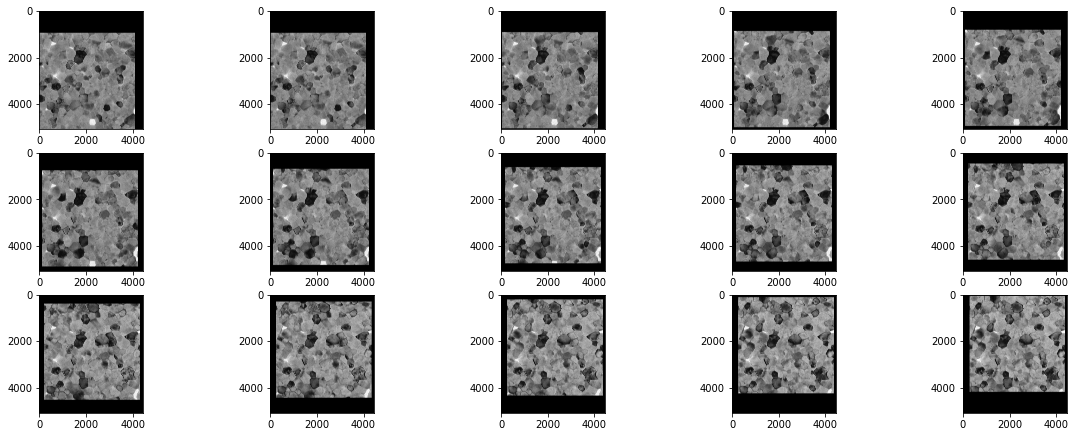

In [ ]:
images = []
for img_path in raw_file_list:
    img = np.load(img_path)
    low_limit,high_limit = np.percentile(img,0.1),np.percentile(img,99.9)
    img[img<=low_limit] = low_limit
    img[img>=high_limit] = high_limit
    img = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    images.append(img)

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image,cmap='gray', vmin=0, vmax=255)

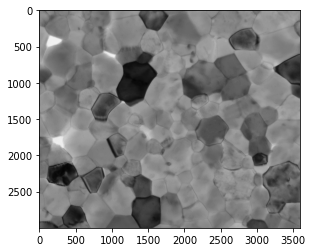

In [ ]:
# view averaged image (from the original image stack, not just these 15 images)
averaged_image_file = os.path.join(data_dir, 'averaged_254.png')
averaged_image = cv2.imread(averaged_image_file, 0)
plt.imshow(averaged_image,cmap='gray', vmin=0, vmax=255)
plt.show()

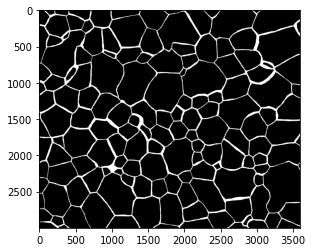

In [ ]:
# view labeled image
binary_image_file = os.path.join(data_dir, 'binary.png')
binary_image = cv2.imread(binary_image_file, 0)
plt.imshow(binary_image,cmap='gray', vmin=0, vmax=255)
plt.show()

###Generate training data


In [ ]:
from generate_training_data_grain import generate_unet_training_data


#~ create directionary if it does not already exist
def mkdir(dir_name):
    if (os.path.exists(dir_name) == False):
        os.makedirs(dir_name)

# mask image blocks unwanted region, so that no training sample is taken from this region.
# for this image sequence, there is no unwanted region, the mask image is a placeholder
mask_file = os.path.join(root_dir,'averaged_254.png')

# the labeled binary image only covers the center region of drift corrected raw images
top = 1008
bottom = 4008
left = 416
right = 4016
	
sample_per_img = 20
random_flip_ud = True
random_flip_lr = True
random_rotate = True    # randomly rotate 90 degrees
	
training_data_dir = os.path.join(save_dir, 'training_images')
ground_truth_dir = os.path.join(save_dir, 'ground_truth')
mkdir(training_data_dir)
mkdir(ground_truth_dir)

generate_unet_training_data(raw_file_list, binary_image_file, mask_file, training_data_dir, ground_truth_dir,
		sample_per_img, top, bottom, left,right, random_rotate, random_flip_ud,	random_flip_lr, small=True)


image: 100%|██████████| 15/15 [00:17<00:00,  1.15s/it]


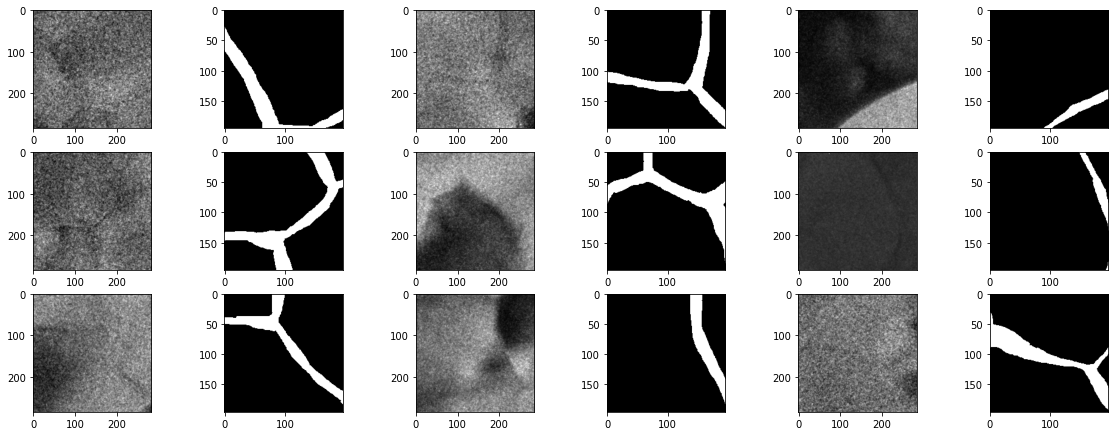

In [ ]:
#view sample training data
images = []
num_pair = 9
for idx in range(num_pair):
    img_path = os.path.join(training_data_dir, str(idx).zfill(6)+'.npy')
    img = np.load(img_path)
    img = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    images.append(img)
    img = cv2.imread(os.path.join(ground_truth_dir, str(idx).zfill(6)+'.png'), 0)
    images.append(img)

plt.figure(figsize=(20,10))
columns = 6
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image,cmap='gray', vmin=0, vmax=255)

In [ ]:
# test GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Train the model

In [ ]:
from unet_training import training_unet

model_name = 'unet_nanorod_model.h5'

epochs = 50
batch_size = 16
	
training_unet(training_data_dir, ground_truth_dir, save_dir, small=True,
		model_name=model_name, epochs=epochs, batch_size=batch_size,raw_format='npy')

100%|██████████| 300/300 [00:06<00:00, 49.08it/s]


Epoch 1/50
13/13 [==============================] - 28s 2s/step - loss: 0.7353 - accuracy: 0.5313 - val_loss: 0.6447 - val_accuracy: 0.8971 - lr: 0.0010
Epoch 2/50
13/13 [==============================] - 11s 839ms/step - loss: 0.6453 - accuracy: 0.6830 - val_loss: 0.6069 - val_accuracy: 0.8971 - lr: 0.0010
Epoch 3/50
13/13 [==============================] - 9s 740ms/step - loss: 0.5986 - accuracy: 0.7884 - val_loss: 0.5796 - val_accuracy: 0.8964 - lr: 0.0010
Epoch 4/50
13/13 [==============================] - 11s 866ms/step - loss: 0.5475 - accuracy: 0.8508 - val_loss: 0.5917 - val_accuracy: 0.7870 - lr: 0.0010
Epoch 5/50
13/13 [==============================] - 10s 822ms/step - loss: 0.5086 - accuracy: 0.8738 - val_loss: 0.6303 - val_accuracy: 0.7396 - lr: 0.0010
Epoch 6/50
13/13 [==============================] - 10s 778ms/step - loss: 0.4793 - accuracy: 0.8843 - val_loss: 0.8448 - val_accuracy: 0.6901 - lr: 0.0010
Epoch 7/50
13/13 [==============================] - 10s 748ms/step -

###classify test image

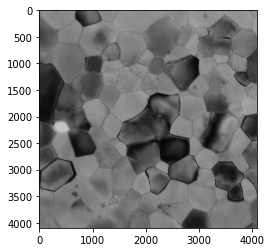

In [ ]:
test_image_file = os.path.join(data_dir,'test_image.npy')
test_image_raw = np.load(test_image_file)
plt.imshow(test_image_raw,cmap='gray')
plt.show()

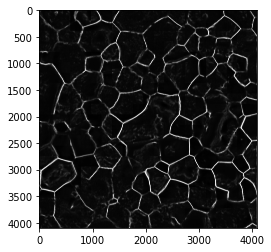

In [ ]:
from tensorflow import keras
from unet_classify_images import classify_images, classify_image

model_file = os.path.join(save_dir, model_name)
model = keras.models.load_model(model_file)
classified_img = classify_image(test_image_raw, model, input_size = 284, output_size = 196)
plt.imshow(classified_img,cmap='gray')
plt.show()